In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from data import *
from baseline_smc import *
from plots import *
from torch.distributions.dirichlet import Dirichlet
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.5.0a0+3bb8c5e cuda: True


In [2]:
## Dataset parameters
num_series = 1
## range of length of tracjectories, need to be positive integers
T_min = 50
T_max = 60
K = 4
D = 2
dt = 5
Boundary = 30
noise_ratio = 10.0

## Model Parameters
num_particles = 50
num_particles_smc = 30
NUM_HIDDEN = 32
NUM_LATENTS = K*K
NUM_OBS = 2 * D

NUM_EPOCHS = 1000
LEARNING_RATE = 1e-3
CUDA = False
RESTORE = False
PATH_ENC = "baseline/smc-%dIS-enc-%s" % (num_particles, datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

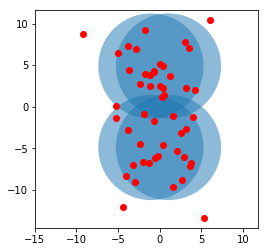

In [3]:
T = 50
noise_cov = np.array([[1, 0], [0, 1]]) * noise_ratio       
init_v = np.random.random(2) * np.random.choice([-1,1], size=2)
v_norm = ((init_v ** 2 ).sum()) ** 0.5 ## compute norm for each initial velocity
init_v = init_v / v_norm * dt ## to make the velocity lying on a circle
STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)

plot_clusters(Y.data.numpy(), mu_ks.data.numpy(), cov_ks.data.numpy(), K)

In [4]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, prior):
        A_sample = torch.zeros((K, K))
        hidden = self.enc_hidden(obs)
        variational = F.softmax(self.latent_dir(hidden), -1).sum(0).view(K, K) + prior
        for k in range(K):
            A_sample[k] = Dirichlet(variational[k]).sample()
        return variational, A_sample

In [5]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer
enc, optimizer = initialize()

In [7]:
KLs = []
EUBOs = []
ESSs = []
ELBOs = []
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    optimizer.zero_grad()
    alpha_trans_0 = initial_trans_prior(K)
    init_v = init_velocity(dt)
    T = np.random.randint(T_min, T_max)
    STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)
    eubo, kl, ess, variational, elbo = oneshot_sampling(enc, alpha_trans_0, Pi, mu_ks, cov_ks, Y, T, D, K, num_particles, num_particles_smc)
    eubo.backward()
    KLs.append(kl.item())
    EUBOs.append(eubo.item())
    ESSs.append(ess)
    ELBOs.append(elbo.item())
    optimizer.step()
    time_end = time.time()
    print('epoch : %d, eubo : %f, elbo : %f,  KL : %f (%ds)' % (epoch, eubo, elbo, kl, time_end - time_start))

if RESTORE:
    enc.load_state_dict(torch.load(PATH_ENC))
else:
    torch.save(enc.state_dict(), PATH_ENC)
    save_params(KLs, EUBOs, ESSs, PATH_ENC)

epoch : 0, eubo : -305.324799, elbo : -314.227844,  KL : 15.724349 (4s)
epoch : 1, eubo : -305.743408, elbo : -317.547607,  KL : 13.332193 (4s)
epoch : 2, eubo : -284.312531, elbo : -296.854919,  KL : 14.032434 (4s)
epoch : 3, eubo : -308.999878, elbo : -321.738312,  KL : 14.692967 (4s)
epoch : 4, eubo : -349.979126, elbo : -359.628479,  KL : 15.264972 (4s)
epoch : 5, eubo : -301.059235, elbo : -314.623077,  KL : 21.337709 (4s)
epoch : 6, eubo : -297.377899, elbo : -307.118774,  KL : 12.740151 (4s)
epoch : 7, eubo : -294.858948, elbo : -306.960144,  KL : 13.116573 (4s)
epoch : 8, eubo : -287.096741, elbo : -293.580444,  KL : 11.967460 (4s)
epoch : 9, eubo : -308.315948, elbo : -316.041382,  KL : 16.613680 (4s)
epoch : 10, eubo : -335.312439, elbo : -348.496613,  KL : 14.691255 (4s)
epoch : 11, eubo : -296.702545, elbo : -306.813477,  KL : 14.578302 (4s)
epoch : 12, eubo : -281.257324, elbo : -292.177063,  KL : 19.029884 (4s)
epoch : 13, eubo : -316.166382, elbo : -329.371246,  KL : 19.

KeyboardInterrupt: 

In [ ]:
plot_dirs(latents_dirs, alpha_trans_0, Z_true, T, K, vmax=15)

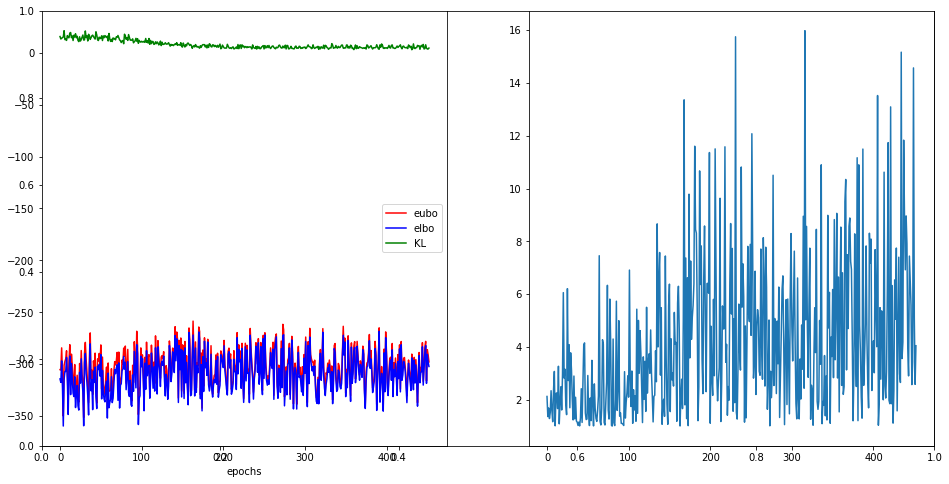

In [9]:
plot_results(EUBOs, ELBOs, KLs, ESSs, PATH_ENC)

In [17]:


Zs, log_weights, log_normalizer = smc_hmm(Pi, A_true, mu_ks, cov_ks, Y, T, D, K, num_particles_smc)
Z_true = resampling_smc(Zs, log_weights)

In [ ]:
accuracy = []
for i in range(1000):
    alpha_trans_0 = initial_trans_prior(K)
    init_v = init_velocity(dt)
    T = np.random.randint(T_min, T_max)
    STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)

    Y_pairwise = torch.cat((Y[:-1].unsqueeze(0), Y[1:].unsqueeze(0)), 0).transpose(0, 1).contiguous().view(T-1, 2*D)
    variational, A_sample = enc(Y_pairwise, alpha_trans_0)
    Zs, log_weights, log_normalizer = smc_hmm(Pi, A_sample, mu_ks, cov_ks, Y, T, D, K, num_particles_smc)
    Z_ret = resampling_smc(Zs, log_weights)

    accuracy.append((Zs_true.nonzero()[:, 1] == Z_ret.nonzero()[:, 1]).sum().float().item() / T)

In [ ]:
accuracy

In [27]:
torch.Tensor([3]) == torch.Tensor([3])

tensor([1], dtype=torch.uint8)